In [94]:
import torch
import torch.nn as nn

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [93]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [80]:
def scattering_graph(values, predicted_values, length, limit):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    
    plt.title('Oil Production')
    plt.ylabel('Total Oil')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(values)
    plt.plot(length,predicted_values)
    plt.show()
    
    plt.title('Oil Production')
    plt.ylabel('Total Oil')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    
    plt.plot(values[-limit:])
    plt.plot(length,predicted_values)
    plt.show()

In [45]:
def metrics(criteria_1, criteria_2):
    rmse_sent = math.sqrt(mean_squared_error(criteria_1, criteria_2))
    mape_sent = mean_absolute_percentage_error(criteria_1, criteria_2)
    mae_sent = mean_absolute_error(criteria_1, criteria_2)
    print ('Test RMSE: %.3f' % rmse_sent,'\nTest MAPE: %.3f' % mape_sent,'\nTest MAE: %.3f' % mae_sent)

In [87]:
def predict(data_normalized, inout_seq, scaler, initial_data, processed_data, data_size, verification_data):
    
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    
    for i in range(epochs):
        for seq, labels in inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            
        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    
    test_inputs = data_normalized[-data_size:].tolist()
    
    model.eval()
    
    for i in range(data_size):
        seq = torch.FloatTensor(test_inputs[-data_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())
    
    actual_predictions = scaler.inverse_transform(np.array(test_inputs[data_size:] ).reshape(-1, 1))
    
    x = np.arange(len(processed_data)-data_size, len(processed_data), 1)
    
    scattering_graph(initial_data, actual_predictions, x, data_size)
    
    metrics(verification_data, actual_predictions)

In [88]:
def implementation():
    
    all_data = pd.read_csv('volvedataset.csv')
    
    all_data['DATEPRD'] = all_data['DATEPRD'].astype('datetime64[ns]')
    
    all_data.fillna(0, inplace=True)
    
    borehole_data = all_data[all_data['NPD_WELL_BORE_NAME'] == '15/9-F-1 C']
    
    oil_data = borehole_data['BORE_OIL_VOL']
    oil_data_float = borehole_data['BORE_OIL_VOL'].values.astype(float)
    test_data_size = 30
    
    train_data = oil_data_float[:-test_data_size]
    test_data = oil_data_float[-test_data_size:]
    
    tt_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    train_data_normalized = tt_scaler.fit_transform(train_data .reshape(-1, 1)) 
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    train_inout_seq = create_inout_sequences(train_data_normalized, test_data_size)
    
    predict(train_data_normalized, train_inout_seq, tt_scaler, oil_data, oil_data_float, test_data_size, test_data)

epoch:   1 loss: 0.02218430
epoch:  26 loss: 0.00366648
epoch:  51 loss: 0.00342964
epoch:  76 loss: 0.00564720
epoch:  99 loss: 0.0035262669


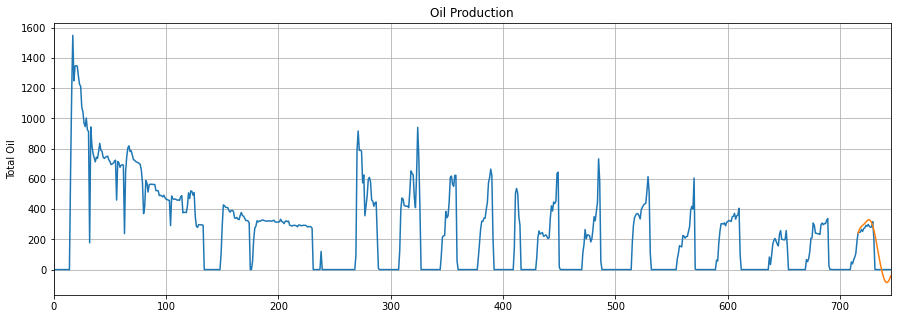

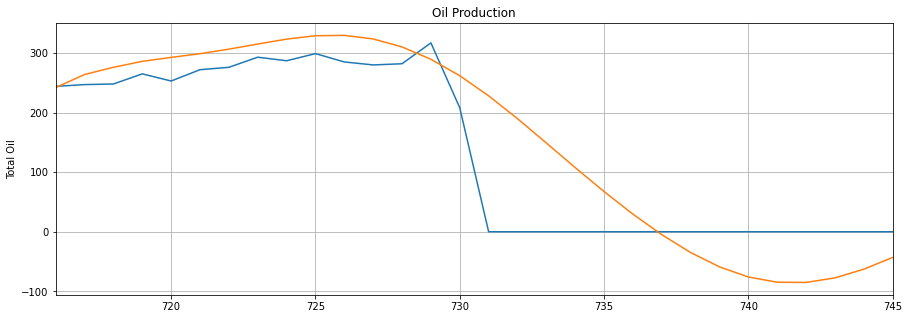

Test RMSE: 77.416 
Test MAPE: 195101728796835840.000 
Test MAE: 58.362


In [92]:
implementation()